In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
def get_XYZ(coords):
    re=6371e3 #m
    lat = np.pi*coords[:,0]/180
    long = np.pi*coords[:,1]/180
    X=re*np.cos(lat)*np.cos(long)
    Y=re*np.cos(lat)*np.sin(long)
    Z=re*np.sin(lat)
    return np.vstack([X,Y,Z])

In [ ]:


mtl=get_XYZ(45.5017,-73.7673)
otw=get_XYZ(45.4215,-75.6972)

np.sqrt(np.sum((mtl-otw)**2))/1000

Shift to XYZ coordinates aligned with Earth's rotation axis.

A baseline is a vector in space. Coordinate transformation change its components, not the vector.

What do components of a baseline look like in uvw coordinate system (XYZ rotated towards direction of observation).

In [ ]:
import datetime
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u

observing_location = EarthLocation(lat=45.5017*u.deg, lon=-73.7673*u.deg)
# observing_location = EarthLocation(lat=45.5017*u.deg, lon=0*u.deg)
observing_time = Time(datetime.datetime.utcnow(), scale='ut1', location=observing_location)
LST = observing_time.sidereal_time('mean')
print(LST.value)

In [ ]:
LST.value-73.7673*24/360

In [ ]:
datetime.datetime.utcnow()

In [34]:
lat=-46.897222*np.pi/180
long=37.774583*np.pi/180
ele=90*np.pi/180 # zenith also lies on meridian. HA will be zero
az=-150*np.pi/180 # north, due east from meridian. hour angle of everything on your meridian is always zero.
dec = np.arcsin(np.sin(lat)*np.sin(ele)+np.cos(lat)*np.cos(ele)*np.cos(az))
HA = np.arcsin(-np.cos(ele)*np.sin(az)/np.cos(dec))
# HA2 = np.arccos((np.cos(lat)*np.sin(ele)-np.sin(lat)*np.cos(ele)*np.cos(az))/np.cos(dec))
print(dec*180/np.pi, "HA in hrs:",HA*180*24/np.pi/360)
GHA=HA-long
print("GHA in hrs", GHA*180*24/np.pi/360)

-46.897222 HA in hrs: 1.711453018024202e-16
GHA in hrs -2.5183055333333333


In [3]:
# get greenwich hour angle using GHA = LHA - long. Then use rotation matrix for uv

def get_uvw(H,dec, D):

    rot=np.asarray([[np.sin(H),np.cos(H),0],\
                   [-np.sin(dec)*np.cos(H),np.sin(dec)*np.sin(H),np.cos(dec)],\
                   [np.cos(dec)*np.cos(H),-np.cos(dec)*np.sin(H),np.sin(dec)]])
    U=np.dot(rot,D)
    return U

In [4]:
import pandas as pd

In [5]:
antlocs = pd.read_csv('hut_gps_coords.txt',sep=',')

In [6]:
antlocs

,ID,lat,lon,name
0,1,-46.828345,37.708538,Cape Davis
1,2,-46.961842,37.708638,Grey Headed
2,3,-46.897222,37.774583,Katedraal
3,4,-46.954750,37.853283,Kildalkey
4,5,-46.872210,37.638895,Mixed Pickle
5,6,-46.838208,37.753349,Repetto's
6,7,-46.966914,37.660113,Rooks
7,8,-46.925667,37.593611,Swartkop's
8,9,-46.962159,37.748721,Watertunnel
9,10,-46.870083,37.843533,Hydro shack


In [6]:
pos=get_XYZ(antlocs.loc[:,['lat','lon']].values)
D = []
freq = 5e6 # 5 MHz
lmbda = 3e8/freq
print(lmbda)
for i in range(12):
    for j in range(i+1,12):
        d = (pos[:,i]-pos[:,j])
#         print(d)
        D.append(d)
D=np.asarray(D).T

60.0


In [8]:
antlocs.loc[antlocs['name']=='Katedraal',["lat","lon"]].values

array([[-46.89722216,  37.7745833 ]])

In [22]:
r=get_XYZ(antlocs[['lat','lon']].values)
r=np.mean(r,axis=1)
r

array([ 3442001.53083816,  2664465.15947449, -4652185.20449894])

In [23]:
north = np.asarray([0,0,1.])
# r = np.mean(pos,axis=1)
# r = get_XYZ(antlocs.loc[antlocs['name']=='Katedraal',["lat","lon"]].values).flatten()
r=get_XYZ(antlocs[['lat','lon']].values)
r=np.mean(r,axis=1).flatten()
print(r.shape)
a = np.dot(r,r)/np.dot(r,north)
north = a*north-r
north = north/np.sqrt(np.dot(north,north))
east = np.cross(north,r)
east = east/np.sqrt(np.dot(east,east))

(3,)


In [25]:
nu=np.linspace(3.5,7,101)
lamda=300/nu
u=np.dot(east,D)
v=np.dot(north,D)
u=np.ravel(np.outer(u,1/lamda))
v=np.ravel(np.outer(v,1/lamda))

In [26]:
uv=np.vstack([u,v])
uv.shape

(2, 6666)

In [92]:
U=get_uvw(GHA,dec,D)/lamda

In [102]:
np.mean(U[:2,:]+uv)

7.738458371993118e-08

In [27]:
def hist_2d(U,nside,RES):
    mat=np.zeros((nside,nside))
    for i in range(U.shape[1]):
        uloc = np.round(U[0,i]/RES).astype(int)
        vloc = np.round(U[1,i]/RES).astype(int)
#         print(f"[{uloc},{vloc}]")
        mat[uloc,vloc]+=1
        mat[-uloc,-vloc]+=1
    return mat

In [92]:
def grid_data(uv,npix,RES):
    grid=np.zeros([npix,npix])
    dk=RES 
    uv_grid=np.asarray(np.round(uv/dk),dtype='int64') 
    print(uv_grid)
    uvgrid=np.append(uv_grid,-uv_grid,axis=0) 
    ii=uvgrid[:,0]<0
    uvgrid[ii,0]=uvgrid[ii,0]+npix
    ii=uvgrid[:,1]<0
    uvgrid[ii,1]=uvgrid[ii,1]+npix
    for i in range(uvgrid.shape[0]):
        grid[uvgrid[i,0],uvgrid[i,1]]=grid[uvgrid[i,0],uvgrid[i,1]]+1.0  
    return grid

In [93]:
def grid_data2(uv,npix,RES):
    grid=np.zeros([npix,npix])
    dk=RES 
    uv_grid=np.asarray(np.round(uv/dk),dtype='int64') 
    print(uv_grid)
    uvgrid=np.append(uv_grid,-uv_grid,axis=0) 
#     ii=uvgrid[:,0]<0
#     uvgrid[ii,0]=uvgrid[ii,0]+npix
#     ii=uvgrid[:,1]<0
#     uvgrid[ii,1]=uvgrid[ii,1]+npix
    for i in range(uvgrid.shape[0]):
        grid[uvgrid[i,0],uvgrid[i,1]]=grid[uvgrid[i,0],uvgrid[i,1]]+1.0  
    return grid

In [39]:
GHA

-0.6592908469178771

In [42]:
uv=-get_uvw(GHA,dec,D)/lamda
GHA_arr = np.linspace(GHA,np.pi,50)
for gha in GHA_arr:
    uv_temp = -get_uvw(gha,dec,D)/lamda
    uv=np.append(uv,uv_temp,axis=1)

In [43]:
uv.shape

(3, 3366)

Text(0, 0.5, 'v (wavelengths)')

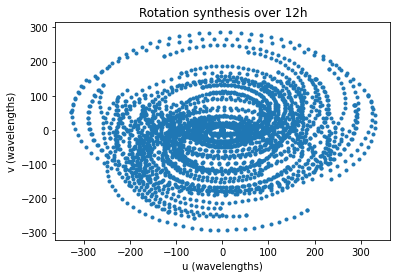

In [45]:
plt.title('Rotation synthesis over 12h')
plt.plot(uv[0,:],uv[1,:],'.')
plt.xlabel('u (wavelengths)')
plt.ylabel('v (wavelengths)')

In [28]:
nside=1024
RES=10
# uv = np.asarray([[12,35,-14,-26],[33,22,-36,-26]])
# print(uv.shape)
# uv2=uv.T.copy()
uv_grid=hist_2d(uv,nside,RES)
# uv_grid1=grid_data(uv2,nside,RES)
# uv_grid2=grid_data2(uv2,nside,RES)

(1024, 1024)


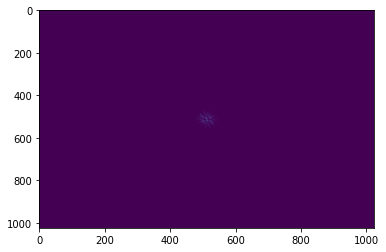

In [26]:
print(uv_grid.shape)
plt.imshow(np.fft.fftshift(uv_grid),aspect='auto')

In [29]:
beam=np.fft.fft2(uv_grid)
img=np.abs(np.fft.fftshift(beam)).T #axis 0 (up down is u = RA. we want RA has left right)
img[:] = img/img.max()

In [30]:
dtheta = 1/(nside*RES)
dtheta = dtheta*180*60/np.pi
print(f"image resolution is {dtheta} arcmin")

image resolution is 0.33571745808446674 arcmin


Text(0, 0.5, '$\\delta dec$ (arcmin)')

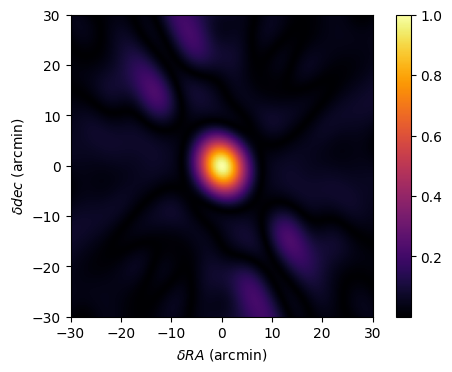

In [35]:
plt.figure(dpi=100)
ext=30
a=int(ext//dtheta)
# print(a, nside)
stamp=img[nside//2-a:nside//2+a+1,nside//2-a:nside//2+a+1]
_=plt.imshow(np.fliplr(stamp),aspect='equal',cmap='inferno',extent=\
          [-ext,ext,-ext,ext])
plt.colorbar()
plt.xlabel(r"$\delta RA$ (arcmin)")
plt.ylabel(r"$\delta dec$ (arcmin)")

Text(0, 0.5, '$\\delta dec$ (arcmin)')

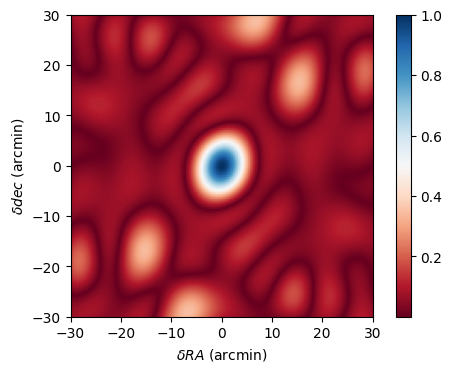

In [96]:
plt.figure(dpi=100)
a=int(30//dtheta)
# print(a, nside)
_=plt.imshow(img[nside//2-a:nside//2+a+1,nside//2-a:nside//2+a+1],aspect='equal',cmap='RdBu',extent=\
          [-30,30,-30,30])
plt.colorbar()
plt.xlabel(r"$\delta RA$ (arcmin)")
plt.ylabel(r"$\delta dec$ (arcmin)")

In [ ]:
90*dtheta

In [ ]:
ticks=np.arange(0,2*a+1,8)

In [ ]:
(ticks-a)*dtheta

In [ ]:
nside//2+a+1

In [ ]:
a+1

In [ ]:
np.linspace(-a*dtheta,(a+1)*dtheta,10)

In [ ]:
xx = np.meshgrid(np.fft.fftfreq(nside)*nside,np.fft.fftfreq(nside)*nside)

In [ ]:
s

In [ ]:
labels=np.fft.fftshift(np.fft.fftfreq(nside)*180*60/np.pi/RES)

In [ ]:
np.fft.fftfreq(16)*16

In [ ]:
np.floor(-0.1)

In [ ]:
uv_grid.shape